In [191]:
import torch
from torch import nn


class Tokenizer:
    def __init__(self, vocabulary: str, special_tokens: list):
        self.special_tokens = special_tokens
        self.vocabulary_dictionary = {}
        self.reverse_vocabulary_dictionary = {}
        vocabulary_list = list(set(vocabulary))
        vocabulary_list = vocabulary_list + special_tokens
        for index, token in enumerate(vocabulary_list):
            self.vocabulary_dictionary[token] = index
            self.reverse_vocabulary_dictionary[index] = token

    def tokenize(self, text: str, pad_before: list = None, pad_after: list = None) -> torch.Tensor:
        split_string = list(text)
        pad_before = [] if pad_before is None else pad_before
        pad_after = [] if pad_after is None else pad_after
        full = pad_before + split_string + pad_after
        out = torch.Tensor([self.vocabulary_dictionary[letter] for letter in full])
        out = out.long()
        return out

    def untokenize(self, tensor: torch.Tensor) -> list:
        out_list = [self.reverse_vocabulary_dictionary[token.item()] for token in tensor]
        return out_list

In [192]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, latent_size: int, vocabulary_size: int, num_attention_heads: int, encode_depth: int,
                 reason_depth: int) -> None:
        super().__init__()

        self.latent_size = latent_size
        self.vocabulary_size = vocabulary_size
        self.encode_depth = encode_depth
        self.reason_depth = reason_depth

        self.lrelu = nn.LeakyReLU()

        self.latent_space = torch.zeros(latent_size)

        self.embedding = nn.Embedding(vocabulary_size, latent_size)

        self.encoder_mha = nn.MultiheadAttention(embed_dim=latent_size, num_heads=num_attention_heads, batch_first=True)
        self.encoder_projection = nn.Linear(latent_size, latent_size)
        self.encoder_mlp = nn.Linear(latent_size, latent_size)
        self.encoder_mha_blocks = nn.ModuleList([self.encoder_mha for _ in range(encode_depth)])
        self.encoder_projection_layers = nn.ModuleList([self.encoder_projection for _ in range(encode_depth)])
        self.encoder_mlp_layers = nn.ModuleList([self.encoder_mlp for _ in range(encode_depth)])
        self.normalize_encoder_latent = nn.LayerNorm(latent_size)

        self.reason_mha = nn.MultiheadAttention(embed_dim=latent_size, num_heads=num_attention_heads, batch_first=True)
        self.reason_projection = nn.Linear(latent_size, latent_size)
        self.reason_mlp = nn.Linear(latent_size, latent_size)
        self.reason_mha_blocks = nn.ModuleList([self.encoder_mha for _ in range(reason_depth)])
        self.reason_projection_layers = nn.ModuleList([self.encoder_projection for _ in range(reason_depth)])
        self.reason_mlp_layers = nn.ModuleList([self.encoder_mlp for _ in range(reason_depth)])
        self.normalize_reason_latent = nn.LayerNorm(latent_size)

        self.normalize_latent = nn.LayerNorm(latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=latent_size),
            self.lrelu,
            nn.Linear(in_features=latent_size, out_features=self.vocabulary_size),
        )

    def zero_latent_space(self):
        self.latent_space.zero_()

    def encode_sequence(self, sequence: torch.Tensor) -> torch.Tensor:
        """ in size [seq_len], out size [self.latent_size] """
        tokens = self.embedding(sequence)
        seq_len = tokens.size(0)
        temp_latent = self.latent_space.clone()

        for index in range(seq_len):
            curr_tok = tokens[index]
            temp_seq = torch.stack([curr_tok, temp_latent])
            for i in range(self.encode_depth):
                attended_seq, _ = self.encoder_mha_blocks[i](temp_seq, temp_seq, temp_seq)
                attended_seq = self.encoder_projection_layers[i](attended_seq)
                attended_seq = self.encoder_mlp_layers[i](attended_seq)
                temp_seq = temp_seq + attended_seq
                temp_seq = self.normalize_encoder_latent(temp_seq)
            temp_latent = temp_seq[1]
        return temp_latent

    def latent_space_reasoning(self, attended_latent_space: torch.Tensor) -> None:
        temp_latent = self.latent_space.clone()
        temp_seq = torch.stack([attended_latent_space, temp_latent])
        for i in range(self.reason_depth):
            attended_seq, _ = self.reason_mha_blocks[i](temp_seq, temp_seq, temp_seq)
            attended_seq = self.reason_projection_layers[i](attended_seq)
            attended_seq = self.reason_mlp_layers[i](attended_seq)
            temp_seq = temp_seq + attended_seq
            temp_seq = self.normalize_reason_latent(temp_seq)
        self.latent_space = (self.latent_space + temp_seq[1]).detach()
        self.latent_space = self.normalize_latent(self.latent_space)

    def decode_latent(self) -> torch.Tensor:
        out = self.decoder(self.latent_space)
        return out

    def inference(self, in_sequence: torch.Tensor, max_len, end_at: str = "</model>"):
        current_length = 0
        self.zero_latent_space()
        temp_latent = self.encode_sequence(in_sequence)
        while current_length < max_len:
            self.latent_space_reasoning(temp_latent)
            out_logits = self.decode_latent()
            out_index = torch.argmax(out_logits, dim=0)
            human_letter = tokenizer.reverse_vocabulary_dictionary[out_index.item()]
            print(f"{human_letter}", end="")
            temp_latent = self.encode_sequence(out_index.unsqueeze(0))
            if human_letter == end_at:
                break
            else:
                current_length += 1

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        self.zero_latent_space()
        attended_latent = self.encode_sequence(tokens)
        self.latent_space_reasoning(attended_latent_space=attended_latent)
        x = self.decode_latent()
        return x

In [193]:
import torch

vocab = "abcdefghijklmnopqrstuvwxyz .,<>/?[]{}-_=+1234567890!@#$%^&*()`~ABCDEFGHIJKLMNOPQRSTUVWXYZ\|"
spec_tok = ["<model>", "</model>", "<user>", "</user>", "<system>", "</system>", "<unknown>", "<padding>",
            "<temp1>", "<temp2>", "<temp3>", "<temp4>", "<temp5>", "<temp6>", "<temp7>", "<temp8>", "<temp9>"]
tokenizer = Tokenizer(vocabulary=vocab, special_tokens=spec_tok)
foo = tokenizer.tokenize(text="hello world", pad_before=["<model>"], pad_after=["</model>"])
print(foo)
unfoo = tokenizer.untokenize(foo)
print(unfoo)
model = Model(latent_size=256, vocabulary_size=len(tokenizer.vocabulary_dictionary), num_attention_heads=1,
              encode_depth=3, reason_depth=3)

# print(model.latent_space)
# temp_lat = model.encode_sequence(foo)
# print(temp_lat.size())
# new_lat = model.latent_space_reasoning(temp_lat)
# print(model.latent_space)
# grr = model.decode_latent()
# print(grr.size())
# print(torch.softmax(grr, dim=0))

tensor([91,  7, 67, 77, 77, 48,  8, 33, 48, 39, 77, 50, 92])
['<model>', 'h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '</model>']


In [194]:
texts = [
    "The fat cat took a nap.",
    "Once upon a time there were 3 cats.",
    "I wish you a merry Christmas, said the large language model.",
    "The little hungry caterpillar ate a lot of apples.",
    "Once upon a time in a faraway land lived 3 little elves.",
    "I like to take long walks outdoors.",
    "There is a certain beauty in the size of the universe.",
    "The quick brown fox jumps over the lazy dog.",
    "The panda eats, shoots and leaves.",
    "You are a machine learning algorithm.",
    "The hit online game Among Us, is perhaps the best piece of multimedia created.",
    "The cat smiled and ate the little mouse.",
    "An elephant ate a monkey.",
    "The sun is shining.",
    "She likes to read books.",
    "He plays football every Saturday.",
    "We are going to the park.",
    "The cat is sleeping on the couch.",
    "I have a big red balloon.",
    "She drinks coffee in the morning.",
    "They enjoy listening to music.",
    "My brother is very tall.",
    "The baby is crying loudly.",
    "We love eating ice cream.",
    "He runs fast in the race.",
    "The birds are singing in the trees.",
    "She wears a blue dress.",
    "I need a glass of water.",
    "The dog is barking outside.",
    "They are watching a movie.",
    "The flowers smell very nice.",
    "He studies hard for his exams.",
    "She has a new bicycle.",
    "The children are playing in the garden.",
    "My father drives a blue car.",
    "We go to school every day.",
    "The moon shines at night.",
    "I write letters to my friend.",
    "She feeds the hungry cat.",
    "He always tells funny jokes.",
    "The teacher is explaining the lesson.",
    "I enjoy painting pictures.",
    "The cake tastes delicious."
]

training_texts = []
for text in texts:
    training_texts.append(tokenizer.tokenize(text=text, pad_before=["<model>"], pad_after=["</model>"]))

E 100/100,000 - 0.10 | Loss: 4.61296
E 200/100,000 - 0.20 | Loss: 3.51539
E 300/100,000 - 0.30 | Loss: 1.93253
E 400/100,000 - 0.40 | Loss: 3.81745
E 500/100,000 - 0.50 | Loss: 1.95673
E 600/100,000 - 0.60 | Loss: 2.53789
E 700/100,000 - 0.70 | Loss: 2.39670
E 800/100,000 - 0.80 | Loss: 4.26346
E 900/100,000 - 0.90 | Loss: 3.65838
E 1,000/100,000 - 1.00 | Loss: 1.80436
E 1,100/100,000 - 1.10 | Loss: 3.32404
E 1,200/100,000 - 1.20 | Loss: 4.73313
E 1,300/100,000 - 1.30 | Loss: 1.70479
E 1,400/100,000 - 1.40 | Loss: 1.13958
E 1,500/100,000 - 1.50 | Loss: 3.36549
E 1,600/100,000 - 1.60 | Loss: 2.76792
E 1,700/100,000 - 1.70 | Loss: 1.43118
E 1,800/100,000 - 1.80 | Loss: 2.58860
E 1,900/100,000 - 1.90 | Loss: 2.49901
E 2,000/100,000 - 2.00 | Loss: 3.21230
E 2,100/100,000 - 2.10 | Loss: 1.38995
E 2,200/100,000 - 2.20 | Loss: 3.59196
E 2,300/100,000 - 2.30 | Loss: 2.58632
E 2,400/100,000 - 2.40 | Loss: 3.43579
E 2,500/100,000 - 2.50 | Loss: 1.15411
E 2,600/100,000 - 2.60 | Loss: 3.09667
E 2,

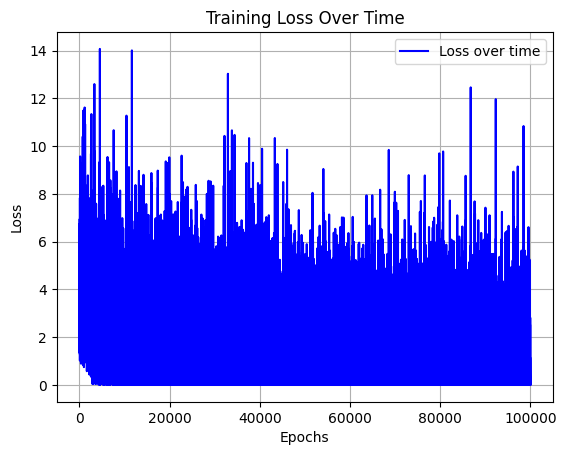

In [195]:
import torch
import random

EPOCHS = 100000
# BATCH_SIZE = 3
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

model.train()
optimizer.zero_grad()

loss_hist = []

for epoch in range(EPOCHS):
    random_text = random.choice(training_texts)
    rand_index = random.randint(1, len(random_text) - 1)
    train_text = random_text[:rand_index]
    label_text = random_text[rand_index]

    raw_logits = model(train_text)
    loss = loss_fn(raw_logits, label_text)
    print(f"E {epoch + 1:,}/{EPOCHS:,} - {((epoch + 1) / EPOCHS) * 100:.2f} | Loss: {loss.item():.5f}") if (
                                                                                                                       epoch + 1) % 100 == 0 else None
    loss.backward()
    loss_hist.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()

import matplotlib.pyplot as plt

plt.plot(loss_hist, label="Loss over time", color="blue")  # Line plot
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [216]:
import torch

txt = "My Among "
foo = tokenizer.tokenize(text=txt, pad_before=["<model>"])
model.inference(in_sequence=foo, max_len=100, end_at="</model>")

pI%%%***********************************************************************************************